In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

df = pd.read_csv('../lesson_30/btcusd_1-min_data.csv')

df.shape
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [10]:
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Пустых значений': missing_values,
    'Процент': missing_percent
})

print("\n", missing_df)


            Пустых значений  Процент
Timestamp                0      0.0
Open                     0      0.0
High                     0      0.0
Low                      0      0.0
Close                    0      0.0
Volume                   0      0.0


In [11]:
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')

df_clean = df.dropna(subset=['Close']).copy()

In [12]:
df_clean.set_index('date', inplace=True)
df_hourly = df_clean['Close'].resample('H').mean().dropna()

print(f"\nКоличество почасовых точек: {len(df_hourly)}")
print(f"\nПервые почасовые значения:")
print(df_hourly.head())


Количество почасовых точек: 122132

Первые почасовые значения:
date
2012-01-01 10:00:00    4.58
2012-01-01 11:00:00    4.58
2012-01-01 12:00:00    4.58
2012-01-01 13:00:00    4.58
2012-01-01 14:00:00    4.58
Name: Close, dtype: float64


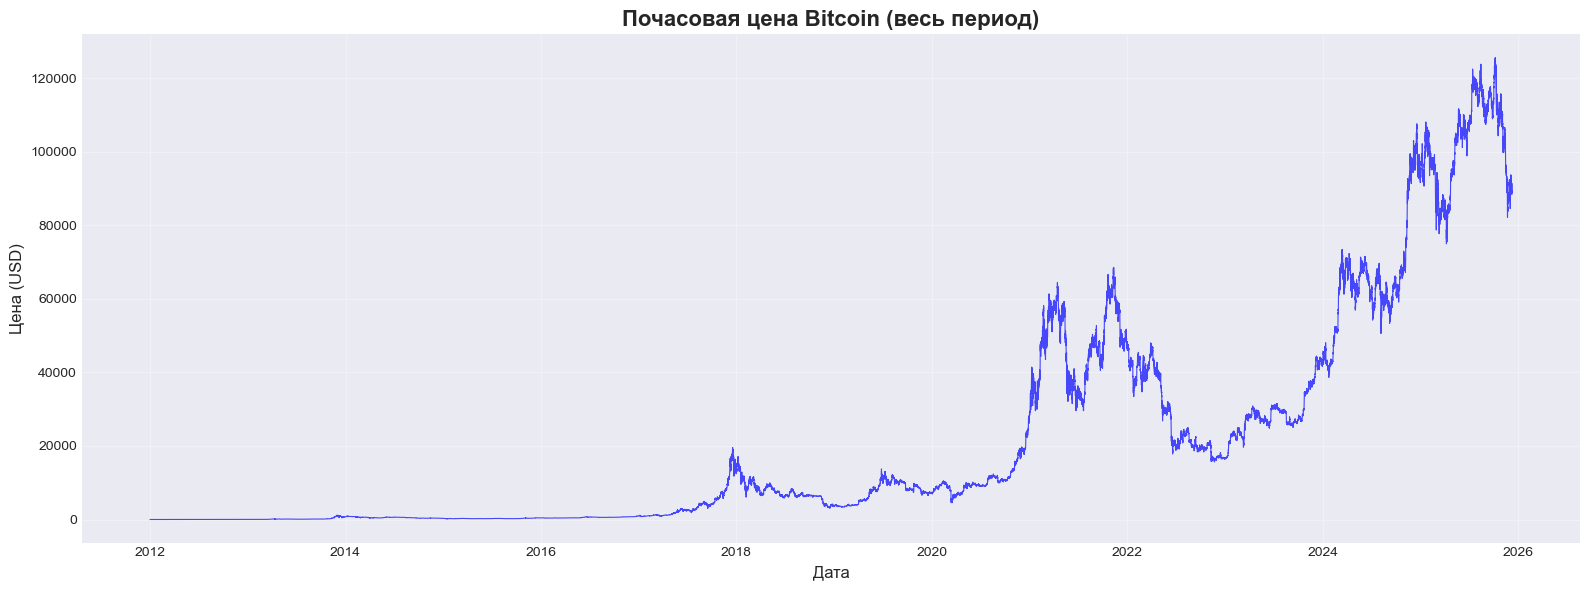

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(df_hourly.index, df_hourly.values, linewidth=0.8, color='blue', alpha=0.7)
plt.title('Почасовая цена Bitcoin (весь период)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

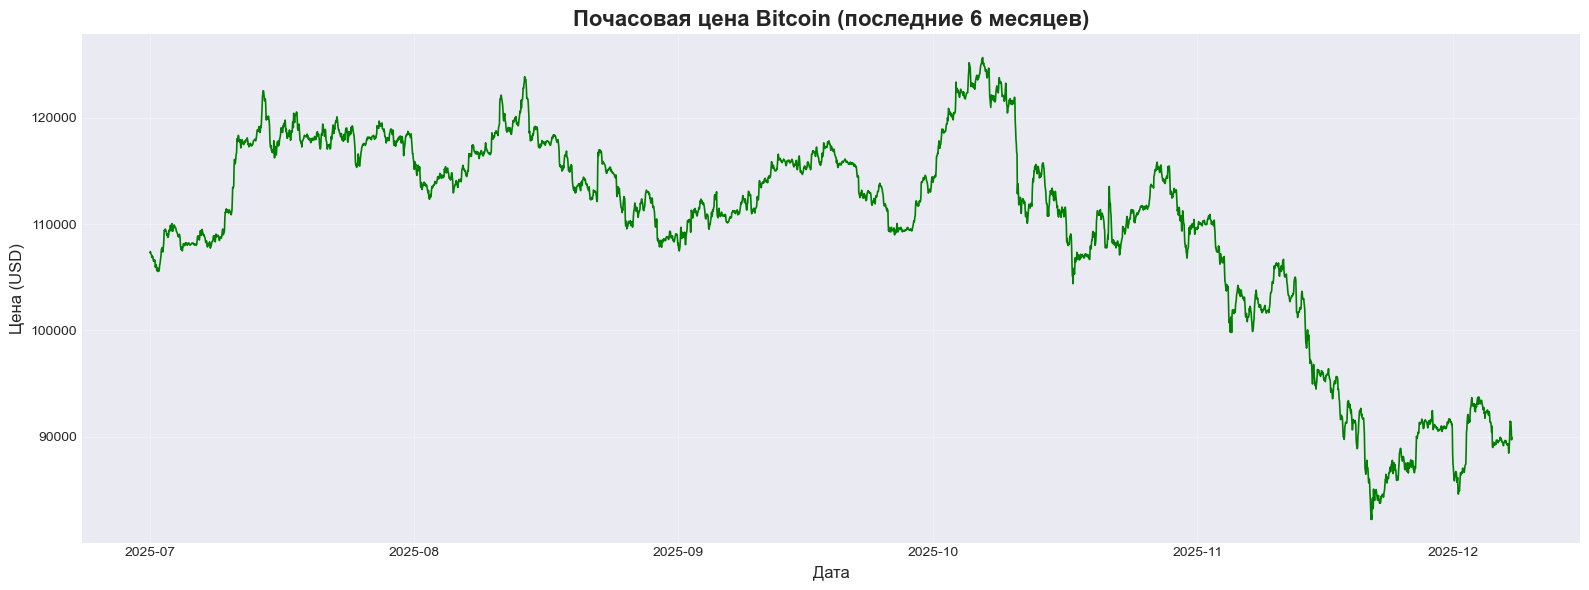

In [14]:
plt.figure(figsize=(16, 6))
df_last_6m = df_hourly.last('6M')
plt.plot(df_last_6m.index, df_last_6m.values, linewidth=1.2, color='green')
plt.title('Почасовая цена Bitcoin (последние 6 месяцев)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
test_size = 30 * 24

test_data = df_hourly.iloc[-test_size:]
train_data = df_hourly.iloc[:-(test_size)]

print(f"\nTrain: {len(train_data)} записей ({train_data.index[0]} - {train_data.index[-1]})")
print(f"Test:  {len(test_data)} записей ({test_data.index[0]} - {test_data.index[-1]})")


Train: 121412 записей (2012-01-01 10:00:00 - 2025-11-07 23:00:00)
Test:  720 записей (2025-11-08 00:00:00 - 2025-12-07 23:00:00)


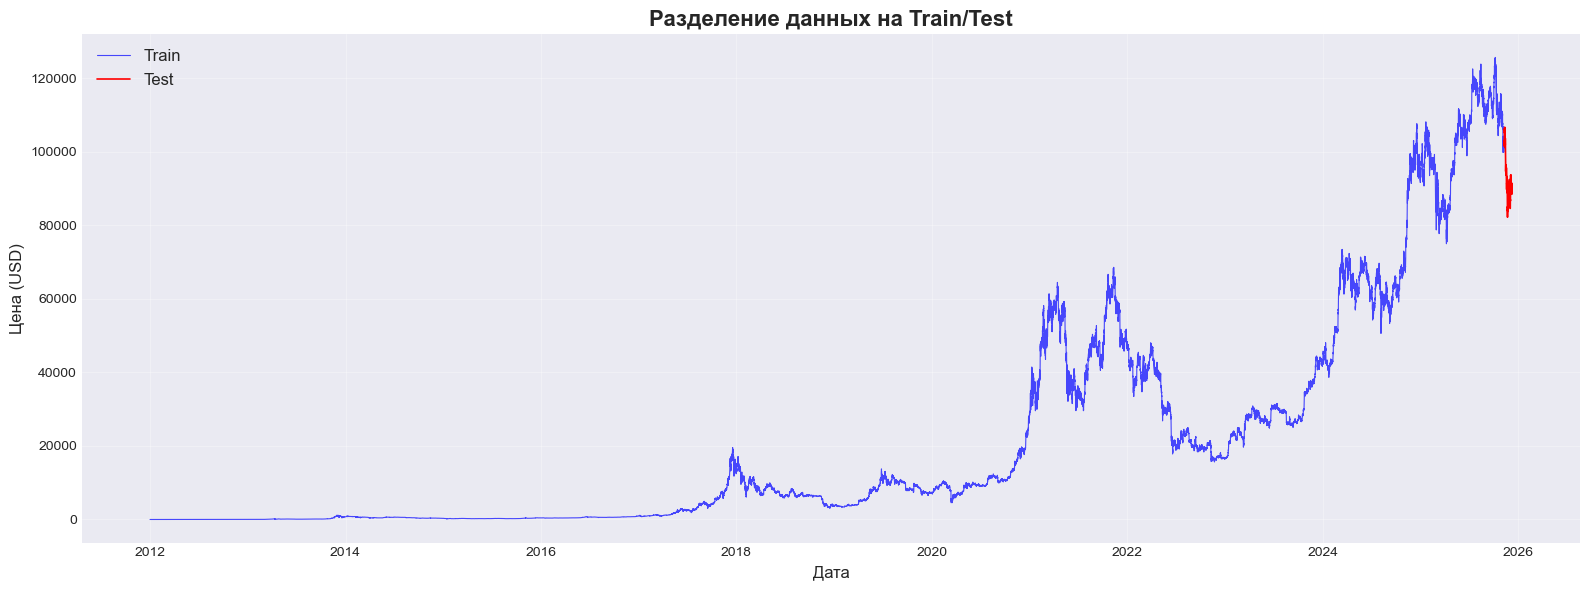

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(train_data.index, train_data.values, label='Train', color='blue', linewidth=0.8, alpha=0.7)
plt.plot(test_data.index, test_data.values, label='Test', color='red', linewidth=1.2)
plt.title('Разделение данных на Train/Test', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [26]:
df_prophet = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data.values
})
# ds — время, поле должно быть типа date или datetime,
# y — числовой показатель, который мы хотим предсказывать.

print(f"\nДанные для обучения Prophet:")
print(df_prophet.head())
print(f"\nРазмер: {df_prophet.shape}")


Данные для обучения Prophet:
                   ds     y
0 2012-01-01 10:00:00  4.58
1 2012-01-01 11:00:00  4.58
2 2012-01-01 12:00:00  4.58
3 2012-01-01 13:00:00  4.58
4 2012-01-01 14:00:00  4.58

Размер: (121412, 2)


In [27]:
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

model.fit(df_prophet)

14:23:54 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = model.make_future_dataframe(periods=test_size, freq='H')
print(f"Количество точек для прогноза: {len(future)}")

forecast = model.predict(future)

forecast_test = forecast.iloc[-test_size:]

print(f"\nПрогноз на тестовый период:")
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

Количество точек для прогноза: 122132

Прогноз на тестовый период:
                        ds           yhat     yhat_lower     yhat_upper
121412 2025-11-08 00:00:00  118534.137190  112599.027962  124522.517113
121413 2025-11-08 01:00:00  118549.627973  112591.362132  124482.874628
121414 2025-11-08 02:00:00  118566.080801  112515.413526  124297.766576
121415 2025-11-08 03:00:00  118582.454506  112639.486630  124930.753598
121416 2025-11-08 04:00:00  118596.985794  112726.211958  124683.459340


In [29]:
y_true = test_data.values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"\nМетрики качества прогноза:")
print(f"MAE (средняя абсолютная ошибка):     ${mae:,.2f}")
print(f"RMSE (корень из средней кв. ошибки): ${rmse:,.2f}")
print(f"MAPE (средняя относительная ошибка): {mape:.2f}%")


Метрики качества прогноза:
MAE (средняя абсолютная ошибка):     $28,528.92
RMSE (корень из средней кв. ошибки): $29,451.36
MAPE (средняя относительная ошибка): 31.31%


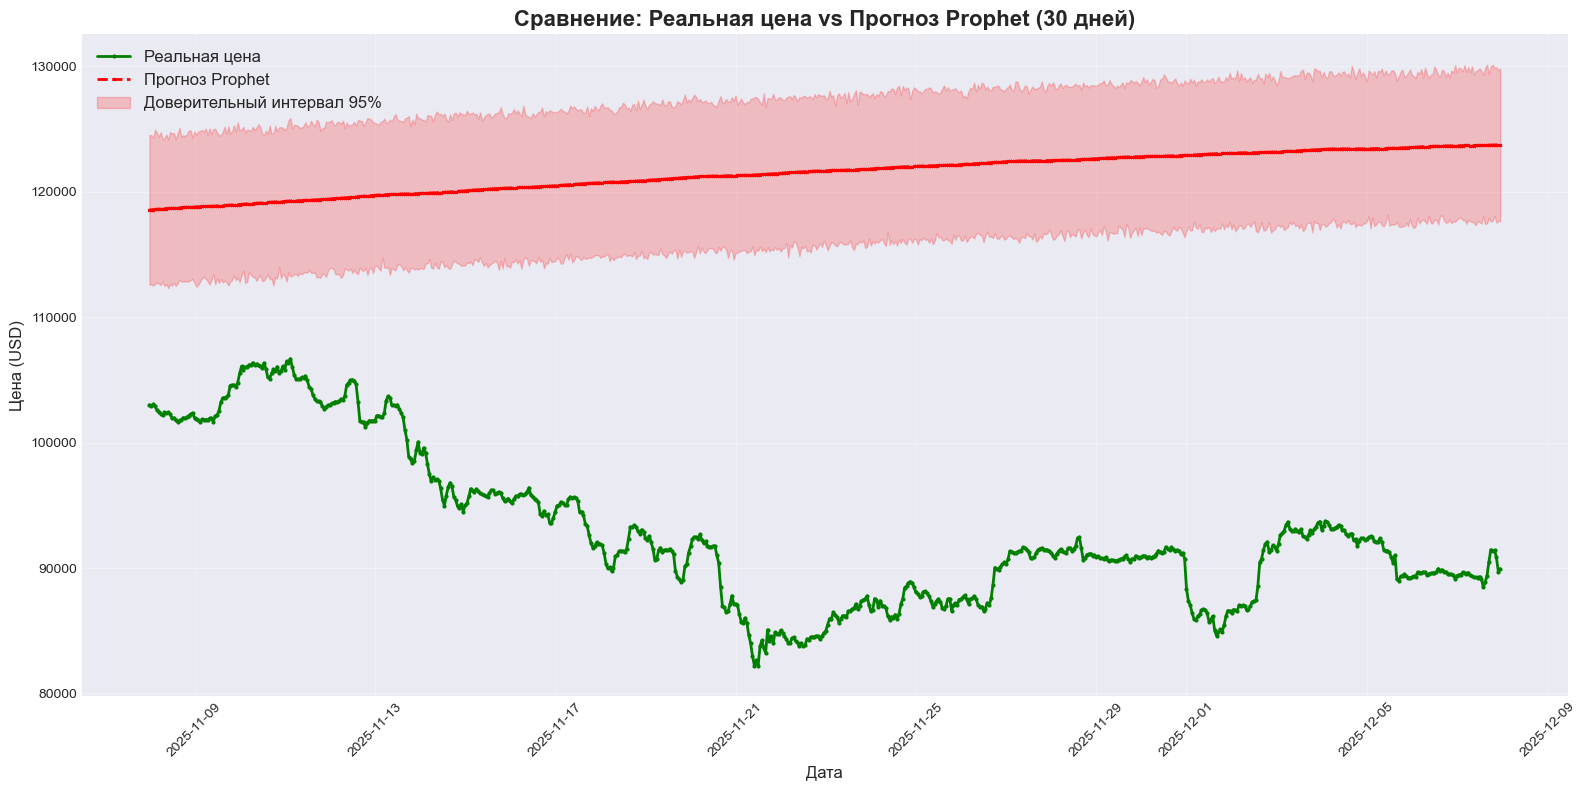

In [30]:
plt.figure(figsize=(16, 8))

plt.plot(test_data.index, test_data.values, label='Реальная цена', color='green', linewidth=2, marker='o', markersize=2)

plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Прогноз Prophet', color='red', linewidth=2, marker='x', markersize=2, linestyle='--')

plt.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], alpha=0.2, color='red', label='Доверительный интервал 95%')

plt.title('Сравнение: Реальная цена vs Прогноз Prophet (30 дней)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена (USD)', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


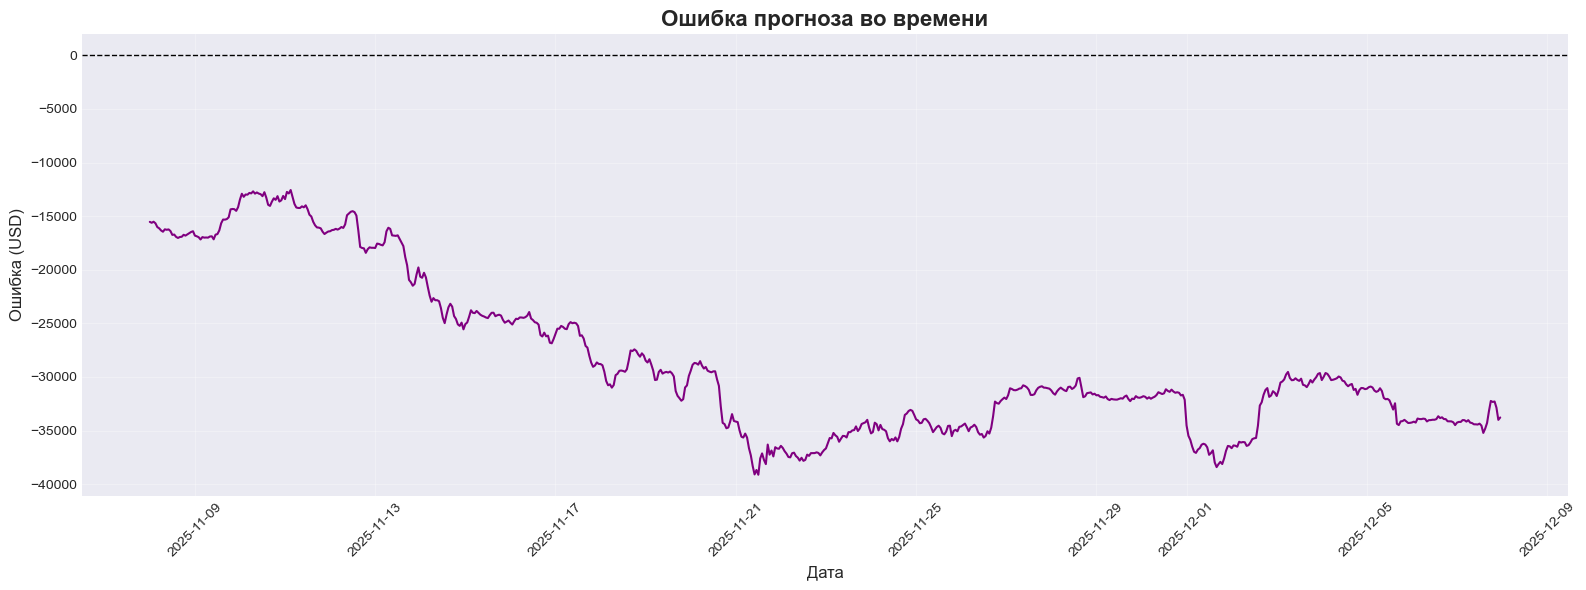

In [31]:
plt.figure(figsize=(16, 6))
error = y_true - y_pred
plt.plot(test_data.index, error, color='purple', linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Ошибка прогноза во времени', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Ошибка (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()